<a href="https://colab.research.google.com/github/singr7/MIRAutoencoder/blob/master/CNNLSTMAutoEncoder_with48bins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

#Mount the google drive
#Create list of numpy files for western and indian dataset

In [2]:
import torch
import numpy as np
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

western_files = []
western_file_dir = "/content/drive/My Drive/MusicResearchColabNB/MelFeatures/Western_mel_numpy"
for r,d, fileList in os.walk(western_file_dir):
  for file in fileList:
    western_files.append(os.path.join(r,file))

indian_files = []
indian_file_dir = "/content/drive/My Drive/MusicResearchColabNB/MelFeatures/Indian_mel_numpy"
for r,d, fileList in os.walk(indian_file_dir):
  for file in fileList:
    indian_files.append(os.path.join(r,file))

print(len(western_files))
print(len(indian_files))

Mounted at /content/drive
7894
2008


# Balance the western dataset by taking files equal to Indian dataset files = 2008

In [3]:
import random 
#randomize the selection. To avoid getting a different random sample with every run, use seed
random.seed(234)
bal_western_files = random.sample(western_files,2008)
len(bal_western_files)

2008

#Define configuration class

In [4]:
class Configuration:
  seq_len = 200  # taking half of the original timesteps extracted 
  input_dim = 48  #num of mels
  embedding_dim = 64
  batch_size = 2
  base_dir = "/content/drive/My Drive/MusicResearchColabNB/vajra/westernAE_48bins"   # need to be edited..
  loss_function = torch.nn.MSELoss(reduction='sum')
  lr=1e-3  # I edited it from 1e-3 to 1e-5
  n_epochs = 4
  model_file = "/content/drive/My Drive/MusicResearchColabNB/vajra/westernAE_48bins/models/mel.pkl"  #need need edits
  results_dir = os.path.join(base_dir, "./results")  # may need edits
  checkpoint_model_file = "/content/drive/My Drive/MusicResearchColabNB/vajra/westernAE_48bins/models/mel_checkpoint.pkl" #may need edits
  kernel_size = 3  #why?
  k_folds = 10 

In [5]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=3, stride=1):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size,stride=stride, groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size)/ stride) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    #x = x.reshape((10, self.seq_len, self.n_features))
   # print('In Encoder')
   # print(x.shape)
    x = self.conv(x)
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    return x

In [6]:
class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=48):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    #print("in decoder", x.shape)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

In [7]:
class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [8]:
x = torch.randn(10, 48, 400)
print(x.shape)
x = x.permute(0, 2, 1)
print(x.shape)

encoder = Encoder(400, 48, embedding_dim=64, kernel_size=3, stride=1)
encoded = encoder(x)
print(encoded.shape)

decoder = Decoder(400, 64, 48)
decoded = decoder(encoded)
print(decoded.shape)

rae = RecurrentAutoencoder(400, 48, 64)
output = rae(x)

print(output.shape)

torch.Size([10, 48, 400])
torch.Size([10, 400, 48])
torch.Size([10, 400, 64])
torch.Size([10, 400, 48])
torch.Size([10, 400, 48])


In [8]:
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SequentialSampler

class CustomDatasetMel(Dataset):

    def __init__(self, dataList):
        self.data = dataList
        #self.labels = labelList

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        import numpy as np
        fileName = self.data[index]
        
        mel_spect = np.load(fileName)
        data = torch.tensor(mel_spect[:,:200], dtype=torch.float)
        data = data.permute(1, 0)
        #data = torch.unsqueeze(data, dim =0)

        #label = torch.tensor(self.labels[index])
        return data

FOLD 0
--------------------------------
length of of train_loader is 904 & length of traindataset is 2008
length of of test_loader is 101
length of of val_loader is 1004
in training loop, epoch 1, step 0, the loss is 286191.3125
in training loop, epoch 1, step 1, the loss is 395862.78125
in training loop, epoch 1, step 2, the loss is 316609.3125
in training loop, epoch 1, step 3, the loss is 359692.0
in training loop, epoch 1, step 4, the loss is 435704.21875
in training loop, epoch 1, step 5, the loss is 443838.5
in training loop, epoch 1, step 6, the loss is 429193.53125
in training loop, epoch 1, step 7, the loss is 300446.8125
in training loop, epoch 1, step 8, the loss is 286934.4375
in training loop, epoch 1, step 9, the loss is 335012.625
in training loop, epoch 1, step 10, the loss is 510005.6875
in training loop, epoch 1, step 11, the loss is 398381.40625
in training loop, epoch 1, step 12, the loss is 365863.34375
in training loop, epoch 1, step 13, the loss is 270006.84375
i

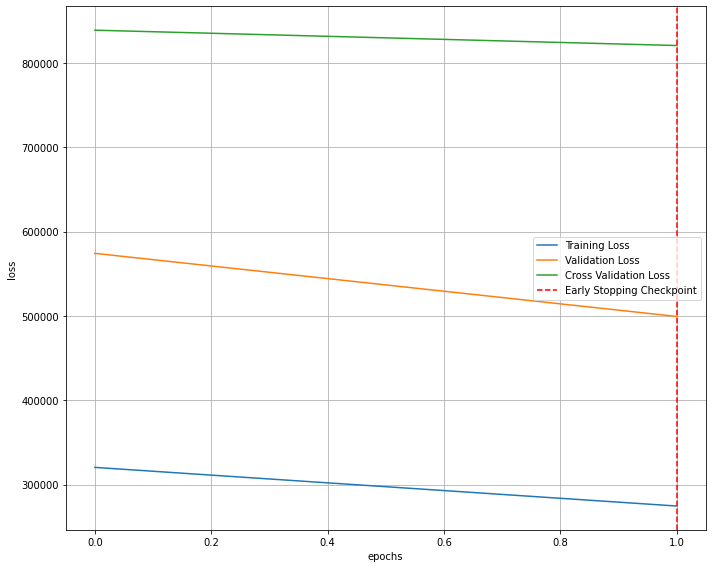

k-fold 0:: Epoch 2: train loss 274639.4610066372 val loss 499365.442914604
in training loop, epoch 3, step 0, the loss is 191929.78125
in training loop, epoch 3, step 1, the loss is 262305.5
in training loop, epoch 3, step 2, the loss is 153051.265625
in training loop, epoch 3, step 3, the loss is 163581.546875
in training loop, epoch 3, step 4, the loss is 216324.859375
in training loop, epoch 3, step 5, the loss is 193626.328125
in training loop, epoch 3, step 6, the loss is 212893.0625
in training loop, epoch 3, step 7, the loss is 280247.40625
in training loop, epoch 3, step 8, the loss is 315477.375
in training loop, epoch 3, step 9, the loss is 191582.25
in training loop, epoch 3, step 10, the loss is 201016.96875
in training loop, epoch 3, step 11, the loss is 302792.03125
in training loop, epoch 3, step 12, the loss is 224879.5
in training loop, epoch 3, step 13, the loss is 279683.9375
in training loop, epoch 3, step 14, the loss is 225177.765625
in training loop, epoch 3, ste

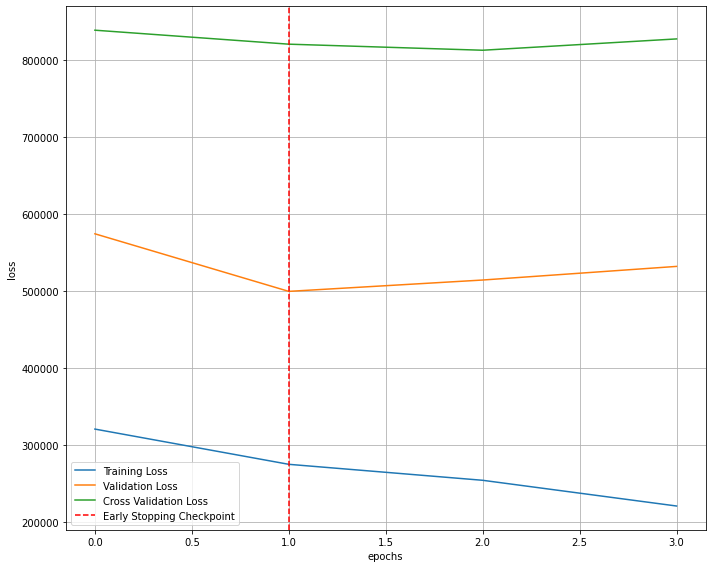

k-fold 0:: Epoch 4: train loss 220462.36599488385 val loss 531802.0779702971
At fold 0 with train_loss:
Before doing mean loss list calc
FOLD 1
--------------------------------
length of of train_loader is 904 & length of traindataset is 2008
length of of test_loader is 101
length of of val_loader is 1004
in training loop, epoch 1, step 0, the loss is 158597.421875
in training loop, epoch 1, step 1, the loss is 264847.625
in training loop, epoch 1, step 2, the loss is 165464.15625
in training loop, epoch 1, step 3, the loss is 405449.8125
in training loop, epoch 1, step 4, the loss is 207159.53125
in training loop, epoch 1, step 5, the loss is 394962.46875
in training loop, epoch 1, step 6, the loss is 190601.390625
in training loop, epoch 1, step 7, the loss is 179462.0625
in training loop, epoch 1, step 8, the loss is 286324.8125
in training loop, epoch 1, step 9, the loss is 199168.3125
in training loop, epoch 1, step 10, the loss is 197540.09375
in training loop, epoch 1, step 11, 

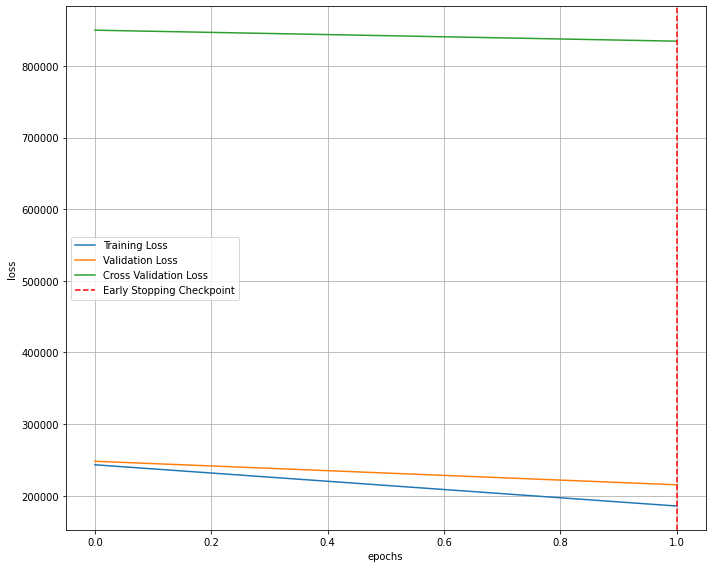

k-fold 1:: Epoch 2: train loss 185672.41613661504 val loss 215289.37956373763
in training loop, epoch 3, step 0, the loss is 102103.796875
in training loop, epoch 3, step 1, the loss is 166689.78125
in training loop, epoch 3, step 2, the loss is 98398.0859375
in training loop, epoch 3, step 3, the loss is 153732.53125
in training loop, epoch 3, step 4, the loss is 87956.390625
in training loop, epoch 3, step 5, the loss is 104862.828125
in training loop, epoch 3, step 6, the loss is 123138.296875
in training loop, epoch 3, step 7, the loss is 147388.0625
in training loop, epoch 3, step 8, the loss is 183471.578125
in training loop, epoch 3, step 9, the loss is 107108.8125
in training loop, epoch 3, step 10, the loss is 120652.1015625
in training loop, epoch 3, step 11, the loss is 122477.6171875
in training loop, epoch 3, step 12, the loss is 142598.328125
in training loop, epoch 3, step 13, the loss is 151861.578125
in training loop, epoch 3, step 14, the loss is 133520.171875
in trai

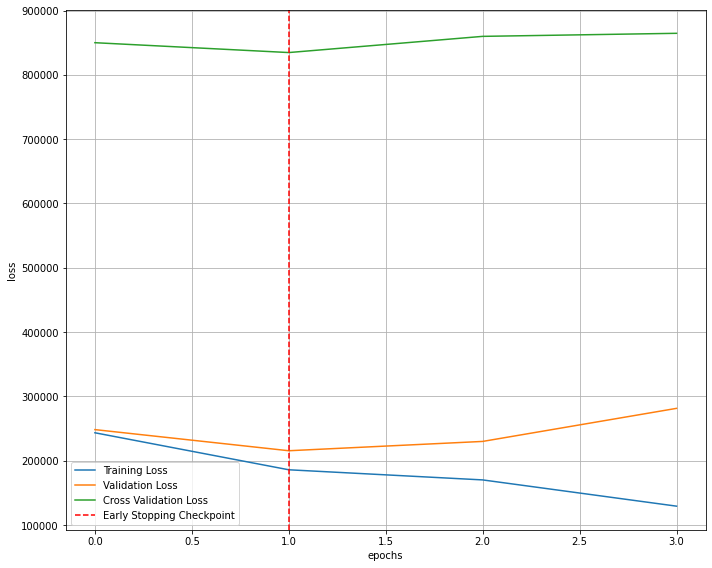

k-fold 1:: Epoch 4: train loss 129092.6284093266 val loss 281211.21782178216


AttributeError: ignored

In [9]:
import copy
import math
import numpy as np

import torch

class TrainingWrapper:

  def __init__(self, config, training_loader, test_loader, device, val_loader=None, cross=10):
    self.config = config
    self.training_loader = training_loader
    self.test_loader = test_loader
    self.val_loader = val_loader
    self.device = device
    self.model = RecurrentAutoencoder(self.config.seq_len, self.config.input_dim, self.config.embedding_dim, device=self.device)
    self.model = self.model.to(self.device)
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.config.lr)
    self.criterion = self.config.loss_function.to(self.device)
    self.history = dict(train=[], val=[], cross_val=[])
    self.best_model_wts = copy.deepcopy(self.model.state_dict())
    self.best_loss = 10000.0
    #print(self.config.base_dir + self.config.model_file)
    torch.save(self.model.state_dict(),  self.config.model_file)
    self.cross = cross
    

  def visualizeTraining(self, epoch, trn_losses, tst_losses, val_losses, save_dir,cross):
    # visualize the loss as the network trained
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10, 8))
    plt.plot(range(0, len(trn_losses)), trn_losses, label='Training Loss')
    if tst_losses:
      plt.plot(range(0, len(tst_losses)), tst_losses, label='Validation Loss')
    if val_losses:
      plt.plot(range(0, len(val_losses)), val_losses, label='Cross Validation Loss')

    minposs = tst_losses.index(min(tst_losses))
    plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')


    plt.xlabel('epochs')
    plt.ylabel('loss')
    # plt.ylim(0, 0.5)  # consistent scale
    # plt.xlim(0, len(trn_losses))  # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(save_dir , 'loss_plot_{}.png'.format(cross)), bbox_inches='tight')

  def train(self):
    self.model.load_state_dict(torch.load(config.checkpoint_model_file))
    for epoch in range(1, self.config.n_epochs + 1):
      self.model = self.model.train()
      train_losses = []
      for i, data in enumerate(self.training_loader,0):
        x = data
        self.optimizer.zero_grad()
        x = x.to(self.device)

        output = self.model(x)
        loss = self.criterion(output, x)

        loss.backward()
        self.optimizer.step()
        train_losses.append(loss.item())
        print("in training loop, epoch {}, step {}, the loss is {}".format(epoch, i, loss.item()))

      val_losses = []
      self.model = self.model.eval()
      with torch.no_grad():
        for i, data in enumerate(self.test_loader):
          x = data
          x = x.to(device)
          output = self.model(x)
          loss = self.criterion(output, x)
          val_losses.append(loss.item())


      cross_val_losses = []
      self.model = self.model.eval()
      with torch.no_grad():
        for i, data in enumerate(self.val_loader):
          x = data
          x = x.to(device)
          output = self.model(x)
          loss = self.criterion(output, x)
          cross_val_losses.append(loss.item())

      train_loss = np.mean(train_losses)
      val_loss = np.mean(val_losses)
      cross_val_loss = np.mean(cross_val_losses)


      self.history['train'].append(train_loss)
      self.history['val'].append(val_loss)
      self.history['cross_val'].append(cross_val_loss)

      if val_loss < self.best_loss:
        self.best_loss = val_loss
        self.best_model_wts = copy.deepcopy(self.model.state_dict())
      #torch.save(self.model.state_dict(),  self.config.checkpoint_model_file)
      if epoch % 2 == 0:
        torch.save(self.model.state_dict(),  self.config.checkpoint_model_file)
        self.visualizeTraining(epoch, trn_losses= self.history['train'], tst_losses=self.history['val'], val_losses =self.history['cross_val'], save_dir=self.config.base_dir + "/results",cross=fold)
      print(f'k-fold {fold}:: Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
    self.model.load_state_dict(self.best_model_wts)
    torch.save(self.model.state_dict(), self.config.model_file)
    return self.model.eval(), self.history


mode = 'train'
data = "mel"
config = Configuration()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import random
import os

def seed_everything(seed=1234):
  
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.backends.cudnn.deterministic = True

def visualizeTraining(epoch, trn_losses, tst_losses, val_losses, save_dir):
    # visualize the loss as the network trained
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10, 8))
    plt.plot(range(0, len(trn_losses)), trn_losses, label='Training Loss')
    
    plt.plot(range(0, len(tst_losses)), tst_losses, label='Validation Loss')
    #if val_losses:
    plt.plot(range(0, len(val_losses)), val_losses, label='Cross Validation Loss')

    minposs = tst_losses.index(min(tst_losses))
    plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')


    plt.xlabel('epochs')
    plt.ylabel('loss')
    # plt.ylim(0, 0.5)  # consistent scale
    # plt.xlim(0, len(trn_losses))  # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(save_dir , 'loss_plot_{}.png'.format("MEAN")), bbox_inches='tight')

seed_everything()

train_data = bal_western_files
val_data = indian_files



# Cross validation runs
# use sklearn KFolds
from sklearn.model_selection import KFold
kfold = KFold(n_splits=config.k_folds , shuffle=True)

train_dataset = CustomDatasetMel(train_data)
val_dataset = CustomDatasetMel(val_data)
#Load the cross val dataset which is Full Indian dataset
#It is identical for all K-folds
crossval_loader = torch.utils.data.DataLoader(
                      val_dataset,
                      batch_size=config.batch_size, 
                      sampler=SequentialSampler(val_dataset), 
                      drop_last=False)  

train_loss_mean_list = []
test_loss_mean_list = []
val_loss_mean_list = []

for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):
  print(f'FOLD {fold}')
  print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
    # Define data loaders for training and testing data in this fold
  train_loader = torch.utils.data.DataLoader(
                      train_dataset, 
                      batch_size=config.batch_size,
                      sampler=train_subsampler,
                      drop_last=False)
  test_loader = torch.utils.data.DataLoader(
                      train_dataset,
                      batch_size=config.batch_size,
                      sampler=test_subsampler,
                      drop_last=False)
    
  print("length of of train_loader is {} & length of traindataset is {}".format(len(train_loader),len(train_dataset)))
  print("length of of test_loader is {}".format(len(test_loader)))
  print("length of of val_loader is {}".format(len(crossval_loader)))
    
  if mode=="train":
    trainingWrapper = TrainingWrapper(config=config, training_loader=train_loader, test_loader=test_loader, device=device, val_loader=crossval_loader, cross=fold)
    model, history = trainingWrapper.train()
    
    try:
      train_loss_mean_list.append(history['train'])
      test_loss_mean_list.append(history['val'])
      val_loss_mean_list.append(history['cross_val'])
    except:
      print('Appendoing to train_loss_mean_list')

    
    print(f'At fold {fold} with train_loss:')

    if data=="mnist":
      #trainingWrapper.show_reconstruction(test_loader=test_loader, n_images=50)
      pass

  elif mode=="test":
    testWrapper = TestingWrapper(config=config, device=device)
    testWrapper.save_reconstruction(test_loader)
  try:
    print('Before doing mean loss list calc')
    train_loss_mean_list_np = np.mean(train_loss_mean_list, axis=0)
    test_loss_mean_list_np = np.mean(test_loss_mean_list, axis=0)
    val_loss_mean_list_np = np.mean(val_loss_mean_list, axis=0)

  except:
    print('# 1 Error happened while doing mean loss list#####')
    
    
    print("train_loss_mean_list",train_loss_mean_list)
    print("test_loss_mean_list",test_loss_mean_list)
    print("val_loss_mean_list",val_loss_mean_list)

  try:
    tn_loss =train_loss_mean_list_np.tolist()
    tt_loss= test_loss_mean_list_np.tolist()
    v_loss= val_loss_mean_list_np.tolist()

    visualizeTraining(0, tn_loss, tt_loss, v_loss, save_dir = config.base_dir + "/results")  
  except:
    print('Out of here..')

In [15]:
train_loss= []
train_losses1=[1,2,3,4]
train_losses2=[3,4,9,8]
train_loss_list=[]
history= dict(train=[])

train_loss=np.mean(train_losses1)
print(train_loss)
history['train'].append(train_loss)
print(history)
train_loss_list.append(history['train'])
print(train_loss_list)
train_loss_list = np.mean(train_loss_list,axis=0)
print(train_loss_list)

2.5
{'train': [2.5]}
[[2.5]]
[2.5]


In [16]:
train_loss= []
train_losses1=[3,4,9,8]
#train_loss_list=[]
#history= dict(train=[])

train_loss=np.mean(train_losses1)
print(train_loss)
history['train'].append(train_loss)
print(history)
try:
  train_loss_list.append(history['train'])
except:
  np.append(train_loss_list,history['train'])
  print(f'train_loss_list exception: {train_loss_list}')

print(train_loss_list)
train_loss_list = np.mean(train_loss_list,axis=0)
print(train_loss_list)

6.0
{'train': [2.5, 6.0]}
train_loss_list exception: [2.5]
[2.5]
2.5
